In [72]:
## Import necessary libraries here (You can add libraries you want to use here)
import os
import random
import cv2
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

In [ ]:
# Load Matches
data = loadmat('content/Part2_data/tracks.mat')

## Code


In [ ]:
def perform_rank3_svd(D):
    """
    Perform SVD on the measurement matrix D and enforce a rank 3 approximation.

    Note: Later steps in the algorithm use W3 to build up the motion and structure matrices.

    Parameters
    ----------
    D : numpy.ndarray
        The measurement matrix of shape (m, n).

    Returns
    -------
    U3 : numpy.ndarray
        The left singular vectors (first 3 columns) of shape (m, 3).
    W3 : numpy.ndarray
        The diagonal matrix containing the square roots of the top three singular values, of shape (3, 3).
    V3 : numpy.ndarray
        The top 3 rows of Vt of shape (3, n).
    """
    
    U, S, V = np.linalg.svd(D, full_matrices=False)
    
    U3 = U[:, :3]
    W3 = np.diag(S[:3])
    V3 = V[:3, :].T

    return U3, W3, V3

def build_ortho_constraints(A):
    """
    Build the orthographic constraints from the motion matrix A.

    Parameters
    ----------
    A : numpy.ndarray, shape (num_frames*2, 3)
        The uncorrected motion matrix from the SVD step, where the top half (ai) corresponds
        to x measurements and the bottom half (aj) corresponds to y measurements.

    Returns
    -------
    ortho_constraints : numpy.ndarray, shape (num_frames*3, 9)
        The left-hand side (lhs) constraint matrix, built using outer products.
    ks (`k` in the slides) : numpy.ndarray, shape (num_frames*3, 1)
        The right-hand side (rhs) vector for the system. The constraints on the squared norms
        are set to 1 (for the first two equations of each frame) while the cross-product
        constraint is set to 0.
    """
    
    # initializing vars
    num_frames = A.shape[0] // 2
    ortho_constraints = np.zeros((num_frames*3, 9))
    ks = np.zeros((num_frames*3, 1))
    
    # for-loop, for each frame, fill in left-hand side (lhs) and right-hand side (rhs)
    for idx in range(0, num_frames, 1):
      ai = A[idx]
      aj = A[num_frames+idx]
      # lhs[idx] -> ai x ai
      ortho_constraints[3*idx] = np.outer(ai, ai).flatten()
      # lhs[idx+1] -> aj x aj
      ortho_constraints[3*idx+1] = np.outer(aj, aj).flatten()
      # lhs[idx+2] -> ai x aj
      ortho_constraints[3*idx+2] = np.outer(ai, aj).flatten()
      
      # rhs -> [1, 1, 0]^T
      ks[3*idx] = 1
      ks[3*idx+1] = 1
      ks[3*idx+2] = 0
    
    return ortho_constraints, ks

def affineSFM(x, y):
  '''
  Affine Structure from Motion (SFM) Algorithm.

  This function implements an Affine Structure from Motion approach to recover
  the 3D structure of a scene and estimate the camera motion from its 2D projections.
  It assumes an orthographic camera model and employs Singular Value Decomposition (SVD)
  to enforce a rank-3 constraint, followed by a correction step that applies orthographic
  projection constraints.

  The algorithm proceeds as follows:
    1. Normalize the measurements: Subtract the mean from each column of x and y so that
        the data is zero mean across each frame.
    2. Construct the measurement matrix D: Stack the transposed normalized x and y coordinates.
        This results in a D of shape (num_frames*2, num_points), where each pair of rows corresponds
        to the x and y measurements for a given frame.
    3. Perform SVD and enforce a rank-3 model: Decompose the measurement matrix and retain only the
        top three singular values and corresponding vectors to satisfy the rank-3 condition.
    4. Apply orthographic constraints: Establish and solve a system of equations based on the
        orthographic projection properties of the affine camera, then use a Cholesky decomposition
        to refine the solution.
    5. Recover the motion and structure matrices:
        - A_corrected: The refined camera motion (affine projection) matrix of shape (num_frames*2, 3)
        - S_corrected: The 3D structure (shape) matrix of the scene of shape (3, num_points)

  Parameters
  ----------
  x : numpy.ndarray, shape (num_points, num_frames)
      A 2D array of x-coordinate feature measurements across frames.
  y : numpy.ndarray, shape (num_points, num_frames)
      A 2D array of y-coordinate feature measurements across frames.

  Returns
  -------
  A_corrected : numpy.ndarray, shape (num_frames*2, 3)
      The refined affine camera motion matrix that maps the 3D structure to the observed 2D coordinates.
  S_corrected : numpy.ndarray, shape (3, num_points)
      The reconstructed 3D structure matrix, representing the positions of feature points in 3D space.
  '''
  # Step 1:
  # Normalize x and y to zero mean.
  # Compute the mean for each column (i.e., each frame).
  # After normalization, the shape should still be (num_points, num_frames)
  
  x_mean = np.mean(x, axis=0, keepdims=True)
  y_mean = np.mean(y, axis=0, keepdims=True)
  x_norm = x - x_mean
  y_norm = y - y_mean

  # Step 2:
  # Create measurement matrix D.
  # The shape of D should be (num_frames*2, num_points)
  D = np.vstack((x_norm.T, y_norm.T))

  # Step 3:
  # Perform SVD and enforce rank 3
  # See https://numpy.org/doc/2.2/reference/generated/numpy.linalg.svd.html for details.
  U3, W3, V3 = perform_rank3_svd(D)

  # Step 4:
  # Create motion and shape matrices A, S
  
  A = U3.dot(np.sqrt(W3))
  S = np.sqrt(W3).dot(V3.T)

  # Step 5:
  # Set up the constraints [ad bd cd ae be ce af bf cf] L = k
  # Or lhs * L = rhs
  # [[a b c]' * [d e f] ...] L = [1 1 0 ...]^T
  # Finish `build_ortho_constraints` and make sure passing the sanity check below
  # Check np.outer for outer product.
  ortho_constraints, rhs = build_ortho_constraints(A)

  # Step 6:
  # Solve the least squares for L
  # See https://numpy.org/doc/2.1/reference/generated/numpy.linalg.lstsq.html
  # for more details
  L = np.linalg.lstsq(ortho_constraints, rhs, rcond=None)[0]
  L = L.reshape(3, 3)

  # Step 7:
  # Cholesky decomposition. See https://numpy.org/doc/2.2/reference/generated/numpy.linalg.cholesky.html
  C = np.linalg.cholesky(L)

  # Step 8:
  # Update A and S with the constraints
  # to get A_corrected and S_corrected
  
  A_corrected = A.dot(C)
  S_corrected = np.linalg.inv(C).dot(S)

  return A_corrected, S_corrected

In [75]:
# Sanity check for rank-3 SVD
np.random.seed(0)  # For reproducibility

D = np.random.randn(8, 10)

# Perform the rank-3 SVD
U3, W3, V3 = perform_rank3_svd(D)

# Print the shapes to check they are as expected.
print("D shape:", D.shape)
print("U3 shape:", U3.shape)  # Expected: (8, 3) if D is (8, 10)
print("W3 shape:", W3.shape)  # Expected: (3, 3)
print("V3 shape:", V3.shape)  # Expected: (10, 3)

print(U3)
print(W3)
print(V3)

D shape: (8, 10)
U3 shape: (8, 3)
W3 shape: (3, 3)
V3 shape: (10, 3)
[[ 0.53246692  0.45719775 -0.15921115]
 [ 0.3115632   0.00164329  0.32281968]
 [ 0.43344853 -0.62446345 -0.58126173]
 [-0.16679875 -0.26983316  0.43462257]
 [-0.4874529   0.34449376 -0.55173433]
 [-0.17789561 -0.25325639  0.11268204]
 [-0.3544282  -0.34054681 -0.15616012]
 [ 0.09397544 -0.17151124  0.04672569]]
[[5.1812973  0.         0.        ]
 [0.         4.76627564 0.        ]
 [0.         0.         4.09283553]]
[[ 0.16000216  0.48858191  0.47244524]
 [ 0.31832224 -0.17030302  0.26373828]
 [ 0.50159274 -0.04793424  0.06489539]
 [ 0.19198533  0.79587716 -0.42622534]
 [ 0.46376952 -0.16087835 -0.33118127]
 [-0.16549708  0.08699357  0.36584415]
 [ 0.3630006   0.06973369  0.42800566]
 [-0.20794436 -0.03024835  0.02322414]
 [ 0.37894031 -0.19559239  0.0010515 ]
 [ 0.15342463 -0.1381398  -0.30676682]]


Expected output:
```
D shape: (8, 10)
U3 shape: (8, 3)
W3 shape: (3, 3)
V3 shape: (10, 3)
[[ 0.53246692  0.45719775 -0.15921115]
 [ 0.3115632   0.00164329  0.32281968]
 [ 0.43344853 -0.62446345 -0.58126173]
 [-0.16679875 -0.26983316  0.43462257]
 [-0.4874529   0.34449376 -0.55173433]
 [-0.17789561 -0.25325639  0.11268204]
 [-0.3544282  -0.34054681 -0.15616012]
 [ 0.09397544 -0.17151124  0.04672569]]
[[5.1812973  0.         0.        ]
 [0.         4.76627564 0.        ]
 [0.         0.         4.09283553]]
[[ 0.16000216  0.48858191  0.47244524]
 [ 0.31832224 -0.17030302  0.26373828]
 [ 0.50159274 -0.04793424  0.06489539]
 [ 0.19198533  0.79587716 -0.42622534]
 [ 0.46376952 -0.16087835 -0.33118127]
 [-0.16549708  0.08699357  0.36584415]
 [ 0.3630006   0.06973369  0.42800566]
 [-0.20794436 -0.03024835  0.02322414]
 [ 0.37894031 -0.19559239  0.0010515 ]
 [ 0.15342463 -0.1381398  -0.30676682]]
```

In [76]:
# Sanity check for build_ortho_constraints()
A_simple = np.array([
    [1, 2, 3],   # ai for frame 1
    [4, 5, 6],   # ai for frame 2
    [7, 8, 9],   # aj for frame 1
    [10, 11, 12] # aj for frame 2
])
constraints_lhs, constraints_rhs = build_ortho_constraints(A_simple)

expected_lhs = np.array(
 [[  1.,   2.,   3.,   2.,   4.,   6.,   3.,   6.,   9.],
 [ 49.,  56.,  63.,  56.,  64.,  72.,  63.,  72.,  81.],
 [  7.,   8.,   9.,  14.,  16.,  18.,  21.,  24.,  27.],
 [ 16.,  20.,  24.,  20.,  25.,  30.,  24.,  30.,  36.],
 [100., 110., 120., 110., 121., 132., 120., 132., 144.],
 [ 40.,  44.,  48.,  50.,  55.,  60.,  60.,  66.,  72.]]
)
expected_rhs = np.array(
 [[ 1.],
 [ 1.],
 [ 0.],
 [ 1.],
 [ 1.],
 [ 0.]]
)
print("Constraints LHS:")
print(constraints_lhs)
print("Constraints RHS:")
print(constraints_rhs)

assert np.allclose(constraints_lhs, expected_lhs), "Constraints LHS not correct"
assert np.allclose(constraints_rhs, expected_rhs), "Constraints RHS not correct"

print("Passed!")

Constraints LHS:
[[  1.   2.   3.   2.   4.   6.   3.   6.   9.]
 [ 49.  56.  63.  56.  64.  72.  63.  72.  81.]
 [  7.   8.   9.  14.  16.  18.  21.  24.  27.]
 [ 16.  20.  24.  20.  25.  30.  24.  30.  36.]
 [100. 110. 120. 110. 121. 132. 120. 132. 144.]
 [ 40.  44.  48.  50.  55.  60.  60.  66.  72.]]
Constraints RHS:
[[1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]]
Passed!


In [77]:
track_x = data['track_x']
track_y = data['track_y']
print(track_x.shape)
print(track_y.shape)

# Remove the nan value
valid_indices = ~np.isnan(track_x).any(axis=1) & ~np.isnan(track_y).any(axis=1)
valid_x = track_x[valid_indices]
valid_y = track_y[valid_indices]
print(valid_x.shape)
print(valid_y.shape)

(500, 51)
(500, 51)
(400, 51)
(400, 51)


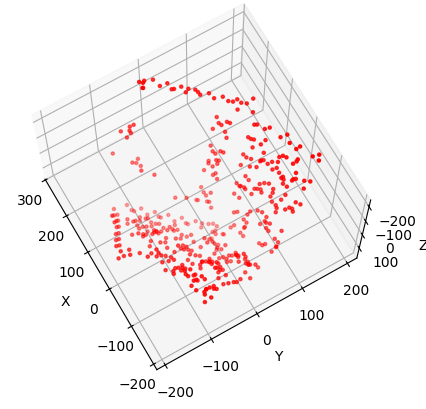

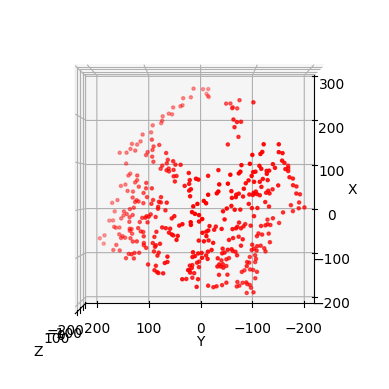

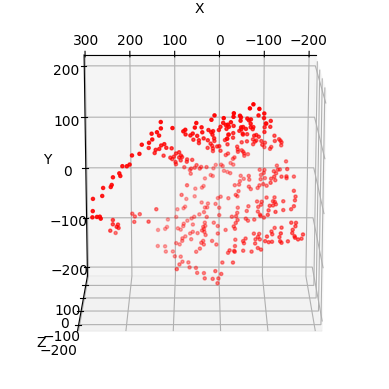

In [ ]:
A, S = affineSFM(valid_x, valid_y)

# Plot the predicted 3D locations of the tracked points for 3 different viewpoints.
viewpoints = [(-110, 30), (90, 180), (-75, 90)]

for elev, azim in viewpoints:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(S[0, :], S[1, :], S[2, :], c='r', marker='.')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

*   Plot the predicted 3D path of the cameras. The camera position for each frame is given by the cross product a_k = a_i x a_j. Normalize a_k to be unit length for consistent results. Give 3 plots, one for each dimension of a_k

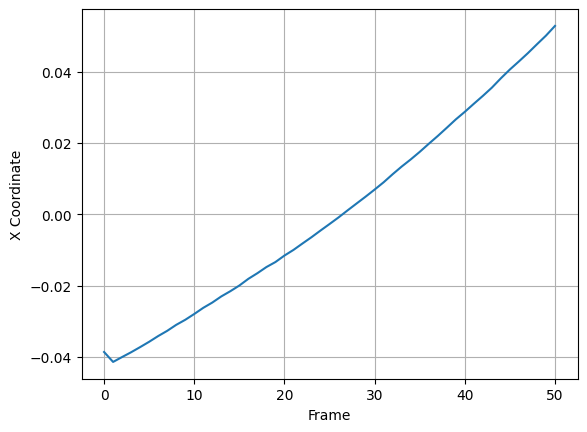

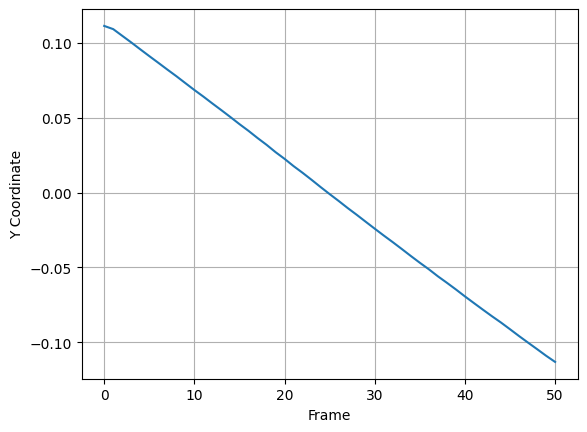

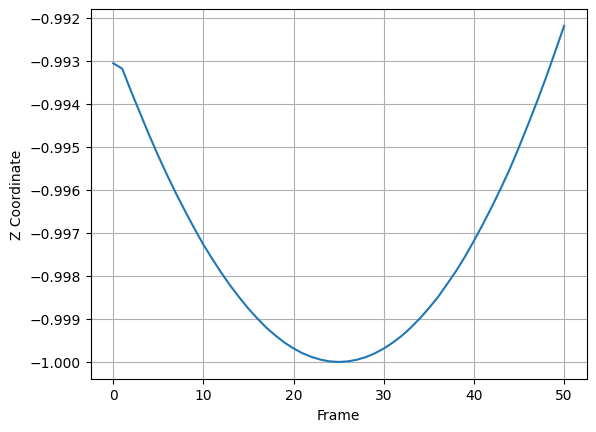

In [79]:
# Plot the predicted 3D path of the cameras. The camera position for each frame is given by the cross product a_k = a_i x a_j.
# Normalize a_k to be unit length for consistent results. Give 3 plots, one for each dimension of a_k
ai = A[:A.shape[0]//2, :]
aj = A[A.shape[0]//2:, :]
ak = np.cross(ai, aj)
ak /= np.linalg.norm(ak, axis=1)[:, np.newaxis]

for i, label in enumerate(['X', 'Y', 'Z']):
    plt.plot(ak[:, i])
    plt.xlabel('Frame')
    plt.ylabel(f'{label} Coordinate')
    plt.grid(True)
    plt.show()